In [ ]:
# Added by Stan
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
#(train_ds, val_ds, test_ds), info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train+test[:50%]', 'test[50%:80%]', 'test[80%:100%]'],
    with_info=True)

In [ ]:
!pip install -U -q segmentation-models

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 5.9 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [ ]:
import keras
# or from tensorflow import keras

keras.backend.set_image_data_format('channels_last')
# or keras.backend.set_image_data_format('channels_first')

In [ ]:
# Download the data
import tensorflow as tf
import tensorflow_datasets as tfds

# (train_ds, val_ds, test_ds), info = tfds.load(
    # 'oxford_iiit_pet:3.*.*',
    # split=['train+test[:50%]', 'test[50%:80%]', 'test[80%:100%]'],
    # with_info=True)
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
# Visualize an image example and its corresponding mask from the dataset:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

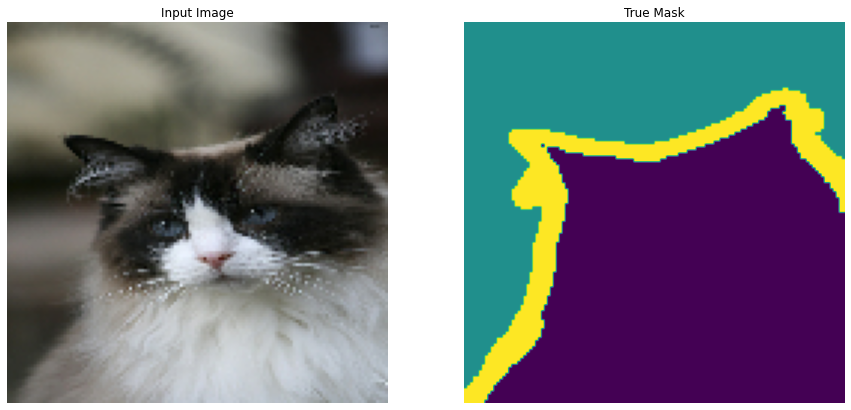

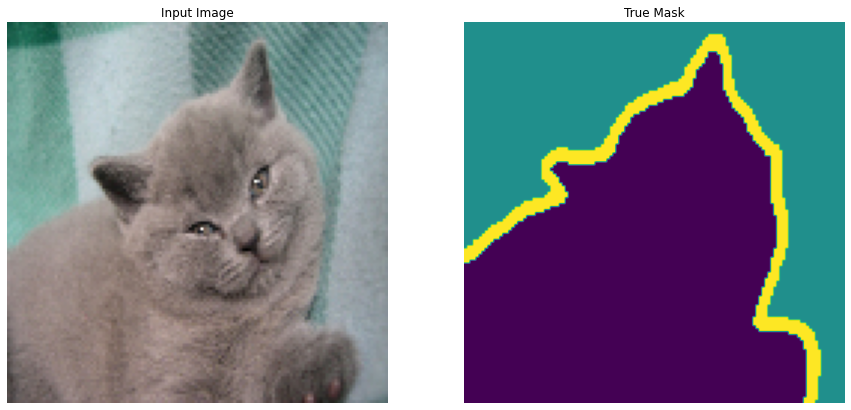

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
model = sm.Unet('mobilenetv2', classes=3, activation='softmax')

/usr/local/lib/python3.9/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

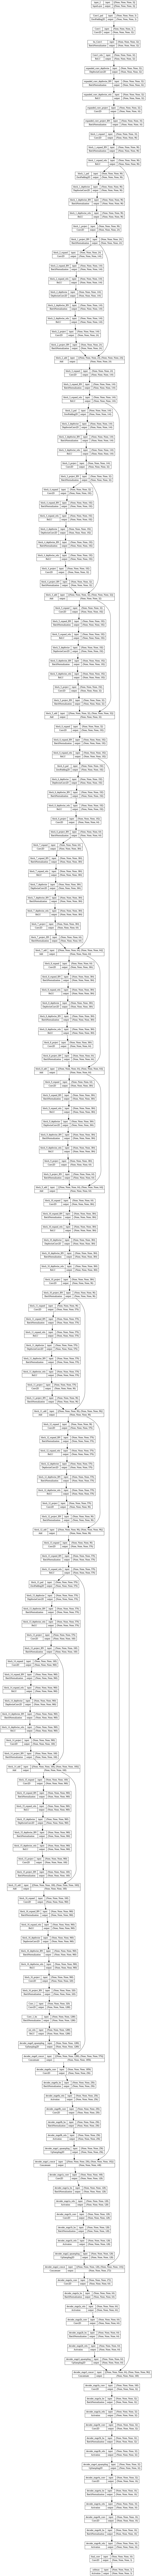

In [ ]:
from keras.backend import sparse_categorical_crossentropy
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
#x_train, y_train, x_val, y_val = load_data(...)
# dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
# preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(x_val)

# define model
# model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model = sm.Unet('mobilenetv2', classes=3, activation='softmax')
model.compile(
    'Adam',
   # loss=sm.losses.bce_jaccard_loss,
    loss=sparse_categorical_crossentropy,
    metrics=[sm.metrics.iou_score],
)

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Fit the model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
# model.fit(
#    x=x_train,
#    y=y_train,
#    batch_size=16,
#    epochs=100,
#    validation_data=(x_val, y_val),
# )
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)
                          # callbacks=[DisplayCallback()])   # Commented by Stan

Epoch 1/20
57/57 [==============================] - 16s 287ms/step - loss: 0.2539 - iou_score: 0.3337 - val_loss: 0.8070 - val_iou_score: 0.3257
Epoch 2/20
57/57 [==============================] - 19s 292ms/step - loss: 0.2144 - iou_score: 0.3358 - val_loss: 0.6637 - val_iou_score: 0.3209
Epoch 3/20
57/57 [==============================] - 16s 279ms/step - loss: 0.1939 - iou_score: 0.3368 - val_loss: 0.6448 - val_iou_score: 0.3228
Epoch 4/20
57/57 [==============================] - 16s 278ms/step - loss: 0.1837 - iou_score: 0.3374 - val_loss: 0.5844 - val_iou_score: 0.3237
Epoch 5/20
57/57 [==============================] - 16s 286ms/step - loss: 0.1776 - iou_score: 0.3377 - val_loss: 1.0309 - val_iou_score: 0.3137
Epoch 6/20
57/57 [==============================] - 16s 280ms/step - loss: 0.1666 - iou_score: 0.3381 - val_loss: 0.5110 - val_iou_score: 0.3261
Epoch 7/20
57/57 [==============================] - 16s 281ms/step - loss: 0.1590 - iou_score: 0.3385 - val_loss: 0.4462 - val_iou

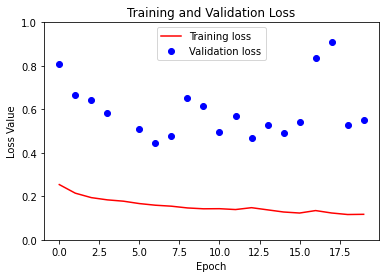

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 28ms/step


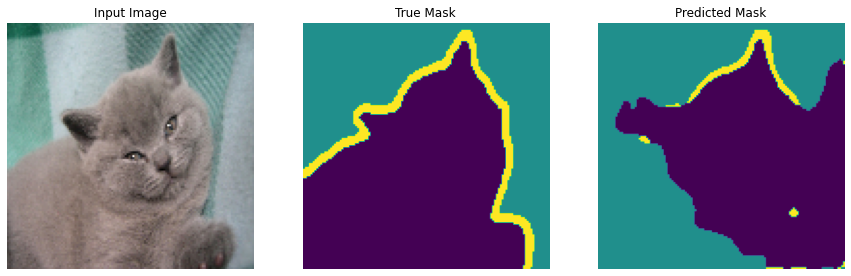

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()
    